## Assignment for Week 6 - K-Means and Hierarchical Clustering

### Exerise:
#### KMeans and Hierarchial Clustering

Collect data from twitter using your choice of hashtag (at least 1000 tweets). 
To gather your Twitter data, I would recommend using the python library tweepy.<br>
Note: Reddit data can be used instead of Twitter data for this assignment.

- You will use both K-Means and HCA to cluster the collected data
- Draw a dendrogram
- Identify number of optimum clusters, and justify how do you pick number of clusters
- List the top 10 most frequent words
- Visualize using wordclouds
- Summarize your findings

### Deliverables:

Upload your notebook's .ipynb file.
   
**Important:** Make sure your provide complete and thorough explanations for all of your analysis. You need to defend your thought processes and reasoning.

## Introduction
***

In this weeks assingment we will be applying two unsupervised learning techniques to a wholesale dataset. We will be looking at the K-means algorithm, and finding the optimal number of clusters. Additionally we will be using Hierarchial Clustering on the same dataset.

### Setup

In [1]:
# data structures and methods
import pandas as pd
import numpy as np

# data collection
import credentials
import praw

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# stats
from numpy import std
from numpy import mean
import scipy.cluster.hierarchy as shc

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings('ignore')

### Data Retrieval

I removed this after looking at the alternative dataset provided in class, but I do have the reddit posts should we need them for another analysis.

In [2]:
reddit = praw.Reddit(client_id=credentials.client_id,
                     client_secret=credentials.client_secret,
                     password=credentials.password,
                     user_agent=credentials.user_agent,
                     username=credentials.username)

In [3]:
# Commented so that I only fetched the 1000ish reddit posts once, They are persisted to a csv for reproducibility.

# reddit_data = {'title': [],
#               'link': [],
#               'author': [],
#               'n_comments': [],
#               'score': [],
#               'text': []}


# ds = reddit.subreddit('datascience').hot(limit=1000)

# for post in list(ds):
#     reddit_data['title'].append(post.title)
#     reddit_data['link'].append(post.permalink)
#     if post.author is None:
#         reddit_data['author'].append('')
#     else:
#         reddit_data['author'].append(post.author.name)
    
#     reddit_data['n_comments'].append(post.num_comments)
#     reddit_data['score'].append(post.score)
#     reddit_data['text'].append(post.selftext)

In [4]:
# ds_df = pd.DataFrame(reddit_data)

In [5]:
# ds_df.to_csv('data.csv', index=False)

### Using Alternative Dataset

In [6]:
df = pd.read_csv('wholesale.csv')

<AxesSubplot:ylabel='Fresh'>

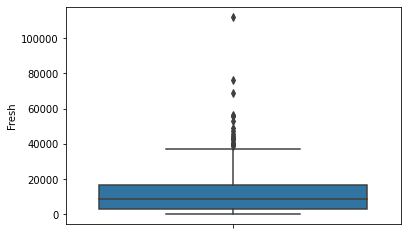

In [7]:
sns.boxplot(y=df['Fresh'])

<AxesSubplot:ylabel='Milk'>

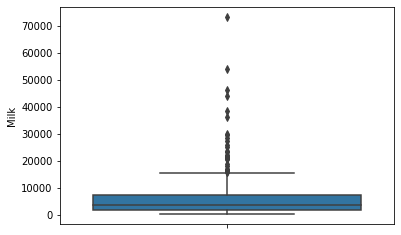

In [8]:
sns.boxplot(y=df['Milk'])

<AxesSubplot:ylabel='Grocery'>

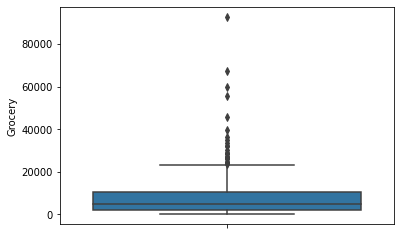

In [9]:
sns.boxplot(y=df['Grocery'])

<AxesSubplot:ylabel='Frozen'>

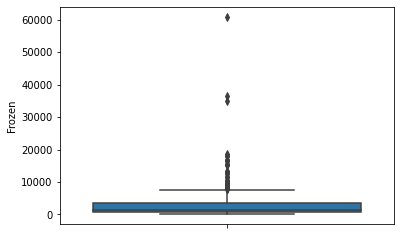

In [10]:
sns.boxplot(y=df['Frozen'])

<AxesSubplot:ylabel='Detergents_Paper'>

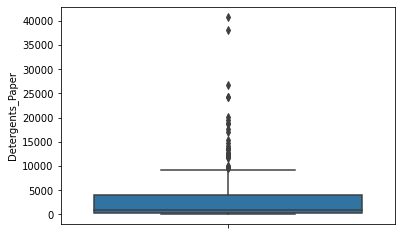

In [11]:
sns.boxplot(y=df['Detergents_Paper'])

<AxesSubplot:ylabel='Delicassen'>

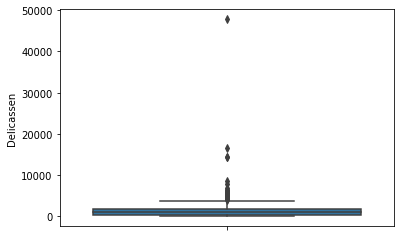

In [12]:
sns.boxplot(y=df['Delicassen'])

All of our numerical features appear to have a large right skew.

In [13]:
df.Channel.value_counts()

1    298
2    142
Name: Channel, dtype: int64

In [14]:
df.Region.value_counts()

3    316
1     77
2     47
Name: Region, dtype: int64

<AxesSubplot:>

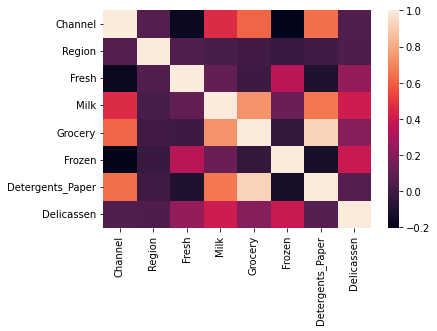

In [15]:
sns.heatmap(df.corr())

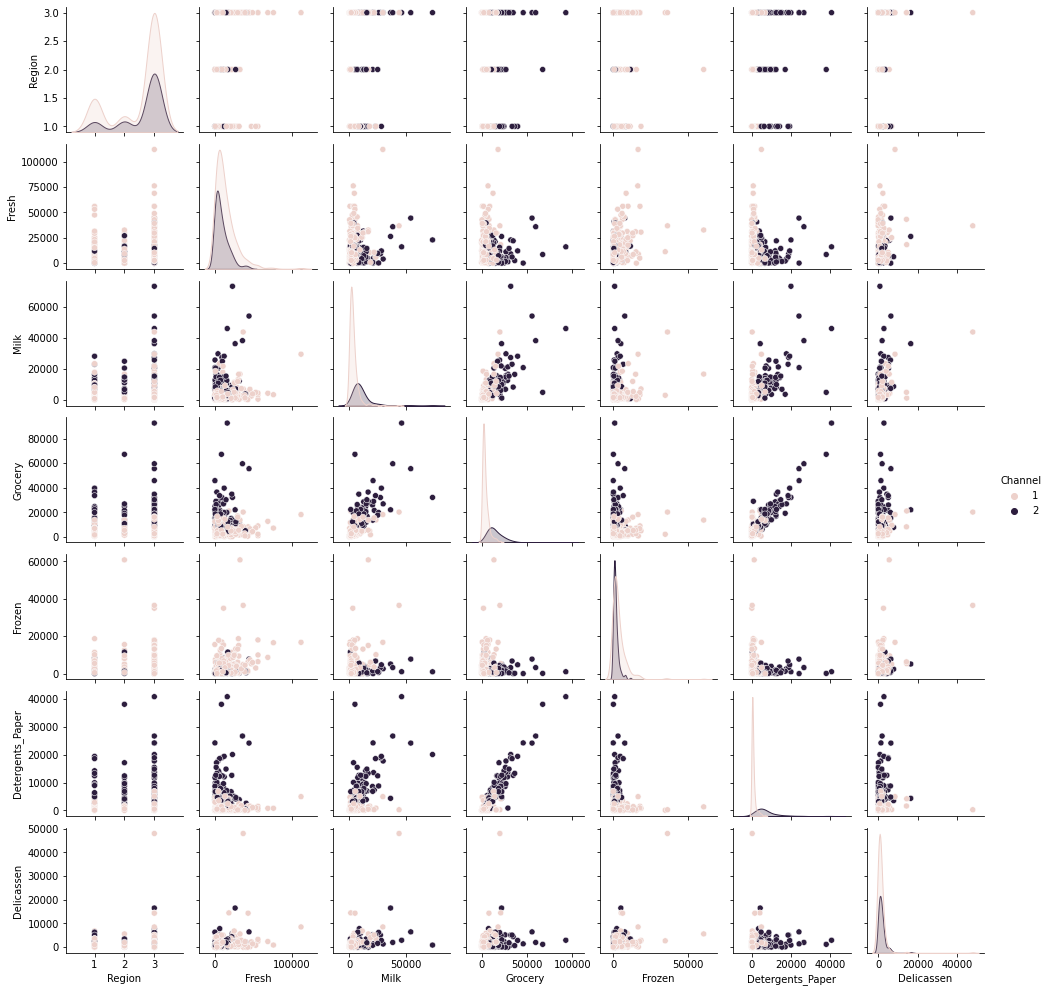

In [16]:
sns.pairplot(df, hue='Channel', diag_kind='kde', size=2)

It does appear that there is a split between Channel 1 and 2 that could be a cluster. I don't want this feature going into our data, so that we can see how the clustering comes out without the data already being categorized. We can come back and compare how our clusters compare to this way of splitting our dataset.

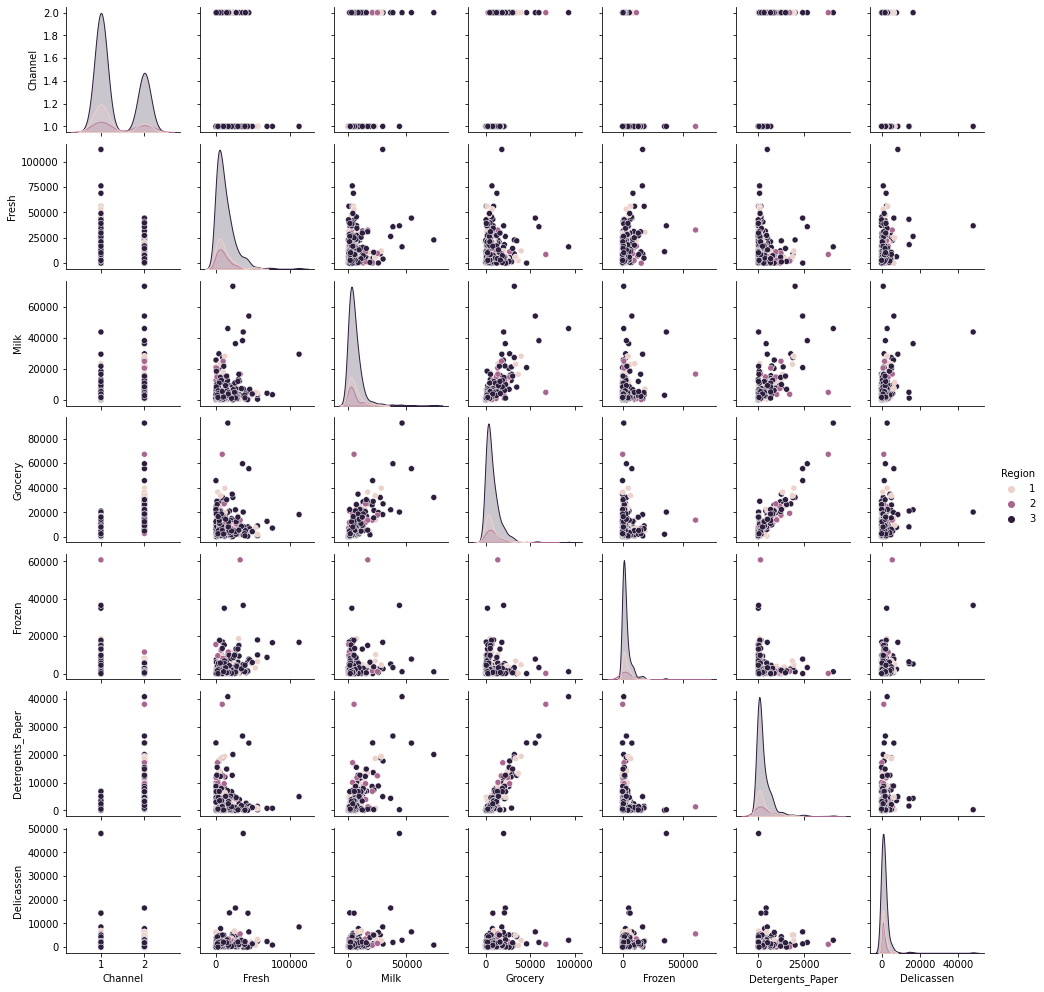

In [17]:
sns.pairplot(df, hue='Region', diag_kind='kde', size=2)

Region appears to be both uncorrelated with the other features, and does not cluster the dataset in an obvious way. There could be a colinearity with Channel and Region together though. At this point I think we are safe to drop both Channel and Region before performing our K-Means and HCA modelling.

In [18]:
df.drop(columns=['Channel', 'Region'], inplace=True)

<AxesSubplot:>

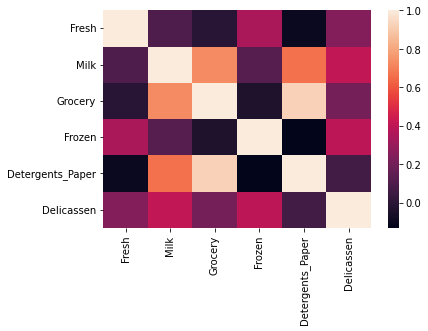

In [19]:
sns.heatmap(df.corr())

In [20]:
df.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


**Removing outliers**

In [21]:
class OutliersHelper:
    def __init__(self, d):
        self.cols = {}
        for col in d:
            cutoff = 3 * std(d[col])
            self.cols[col] = {'top': mean(d[col]) + cutoff,
                              'bottom': mean(d[col]) - cutoff}
    def mark_to_remove_outliers(self, d):
        for rowIdx, row in d.iterrows():
            for colIdx, value in row.items():
                if value > self.cols[colIdx]['top']:
                    d.at[rowIdx, 'remove'] = True
                elif value < self.cols[colIdx]['bottom']:
                    d.at[rowIdx, 'remove'] = True

In [22]:
df['remove'] = False
helper = OutliersHelper(df)
helper.mark_to_remove_outliers(df)
df['remove'].value_counts()

False    414
True      26
Name: remove, dtype: int64

In [23]:
# remove the outliers
df = df[df['remove'] != True]

**Normalize dataset**

In [24]:
scaled_data_array = normalize(df)
scaled_df = pd.DataFrame(scaled_data_array, columns=df.columns)

Our dataset is now scaled and outliers have been addressed, now we can move onto applying our different models to the dataset.

## K-Means
***

I am going to start with 2 clusters, then we can test against our two main metrics to determine the optimal k-value. First using the scree graph and the elbow, with the second being optimizing the silhouette score.

**Optimizing with Scree Plot**

In [25]:
# Using within sum of squares to determine the optimal number of clusters for the final model. 

# determine the optimal number of clusters 
sum_sq= []

# fit the model for a range of 2 to 15 clusters and add to sum_sq[]
for n in range (2,20):
    print('Calculating for ',n,' clusters')
    
    # random_start makes the results reproducible 
    # n_jobs=-1 means run with all machine processors
    model = KMeans(n_clusters=n, random_state=42)
    model.fit(scaled_df)
    sum_sq.append(-model.score(scaled_df))

Calculating for  2  clusters
Calculating for  3  clusters
Calculating for  4  clusters
Calculating for  5  clusters
Calculating for  6  clusters
Calculating for  7  clusters
Calculating for  8  clusters
Calculating for  9  clusters
Calculating for  10  clusters
Calculating for  11  clusters
Calculating for  12  clusters
Calculating for  13  clusters
Calculating for  14  clusters
Calculating for  15  clusters
Calculating for  16  clusters
Calculating for  17  clusters
Calculating for  18  clusters
Calculating for  19  clusters


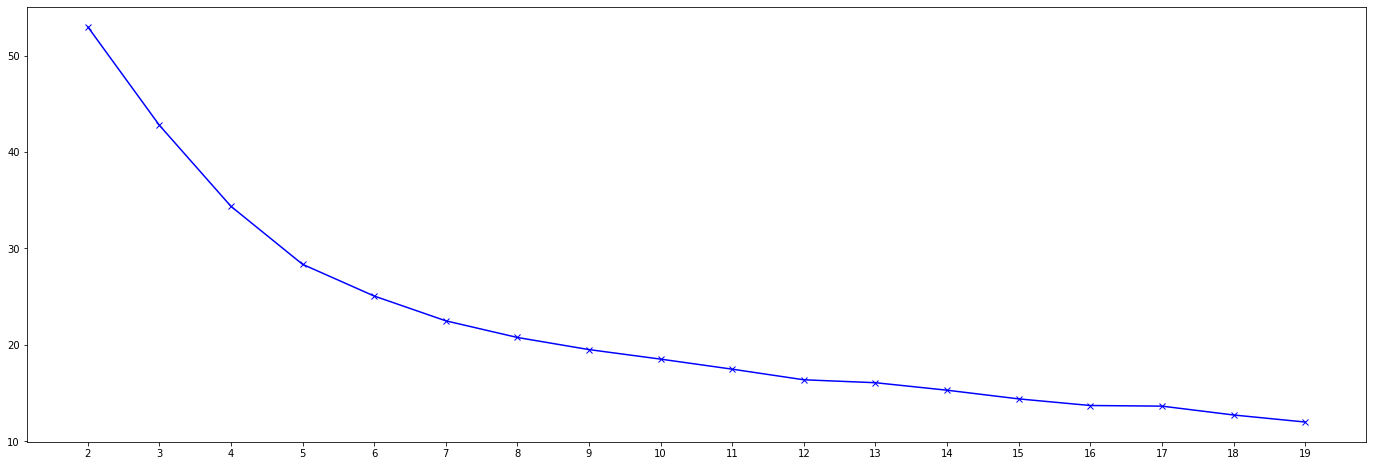

In [26]:
# make our scree plot to visually see the optimal number of clusters

plt.figure(figsize=(24,8))
plt.xticks(range(2, 20))
plt.plot(range(2, 20), sum_sq, 'bx-')

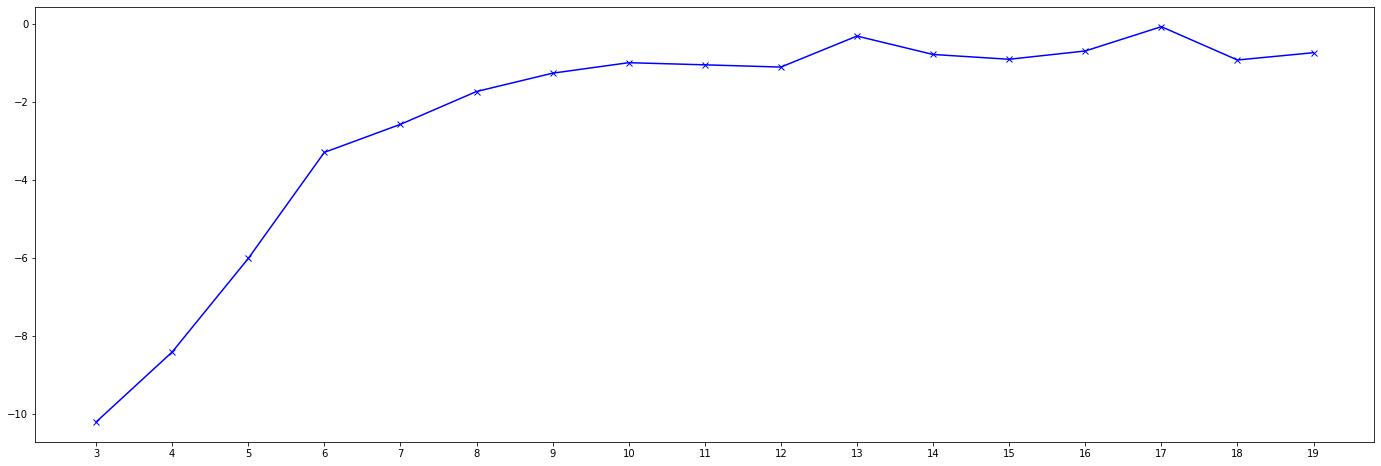

In [27]:
# compare the scree plot with a np.diff() plot

plt.figure(figsize=(24,8))
plt.xticks(range(2, 20))
plt.plot(range(3, 20), np.diff(sum_sq), 'bx-')

Between our diff plot and our scree plot it looks like k = 10 clusters is a good candidate for our elbow.

In [28]:
model = KMeans(n_clusters=10, random_state=42)
model.fit(scaled_df)

# gather the predictions
preds= model.predict(scaled_df)

In [29]:
score = silhouette_score(scaled_df, preds)
score

0.2901559610172529

Text(0.5, 1.0, 'Projection of the clustering on a the axis of the PCA')

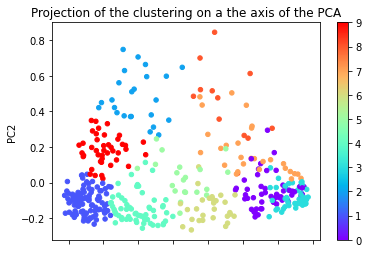

In [30]:
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(scaled_df)
data_reduced = pd.DataFrame(data_reduced)

ax = data_reduced.plot(kind='scatter', x=0, y=1, c=preds, cmap='rainbow')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Projection of the clustering on a the axis of the PCA')

**Optimizing with silhouette score**

In [31]:
# fit the model for clusters and add to sum_sq[]
for n in range (2,20):
    # random_state makes the results reproducible 
    model = KMeans(n_clusters=n, random_state=42)
    model.fit(scaled_df)
    
    # gather the predictions
    preds= model.predict(scaled_df)
    score = silhouette_score(scaled_df, preds)
    print('Silhouette score for ',n,' clusters: ',score)

Silhouette score for  2  clusters:  0.5024854331019207
Silhouette score for  3  clusters:  0.4164312729849782
Silhouette score for  4  clusters:  0.3624866878073696
Silhouette score for  5  clusters:  0.37334220973330534
Silhouette score for  6  clusters:  0.3617601964036387
Silhouette score for  7  clusters:  0.3327803266734948
Silhouette score for  8  clusters:  0.32438479523815394
Silhouette score for  9  clusters:  0.3110147439523043
Silhouette score for  10  clusters:  0.2901559610172529
Silhouette score for  11  clusters:  0.3035454618102397
Silhouette score for  12  clusters:  0.2954073462608313
Silhouette score for  13  clusters:  0.2515677199457754
Silhouette score for  14  clusters:  0.2434672848548888
Silhouette score for  15  clusters:  0.26078495527760326
Silhouette score for  16  clusters:  0.24154574905426782
Silhouette score for  17  clusters:  0.2412596893221167
Silhouette score for  18  clusters:  0.2626876209269947
Silhouette score for  19  clusters:  0.2416165180266

<AxesSubplot:ylabel='Density'>

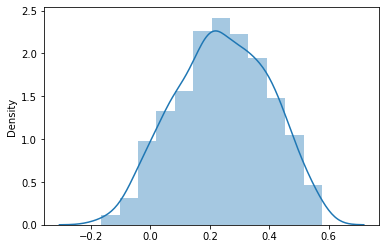

In [32]:
scores = silhouette_samples(scaled_df, preds)
sns.distplot(scores)

In [33]:
model = KMeans(n_clusters=17, random_state=42)
model.fit(scaled_df)

# gather the predictions
preds= model.predict(scaled_df)

In [34]:
score = silhouette_score(scaled_df, preds)
score

0.2412596893221167

Text(0.5, 1.0, 'Projection of the clustering on a the axis of the PCA')

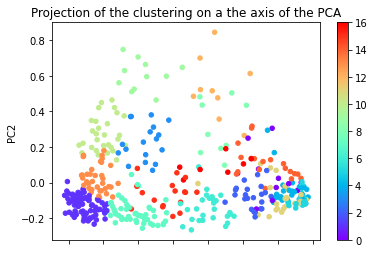

In [35]:
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(scaled_df)
data_reduced = pd.DataFrame(data_reduced)

ax = data_reduced.plot(kind='scatter', x=0, y=1, c=preds, cmap='rainbow')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Projection of the clustering on a the axis of the PCA')

## Hierarchical Clustering
***

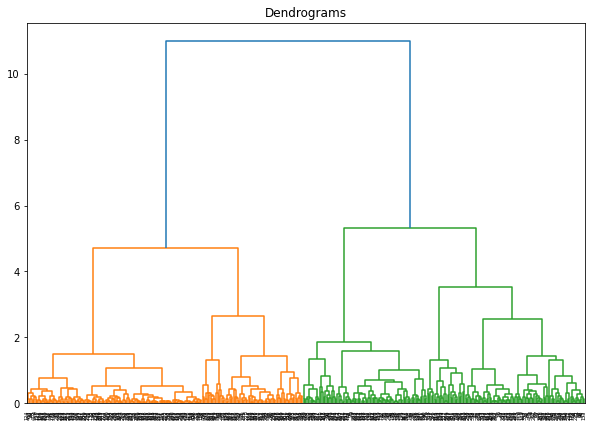

In [36]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(scaled_df, method='ward'))

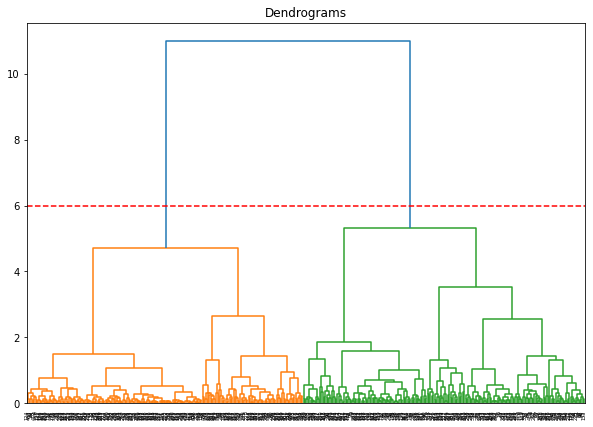

In [37]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(scaled_df, method='ward'))
plt.axhline(y=6, color='r', linestyle='--')

In [38]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
preds = cluster.fit_predict(scaled_df)

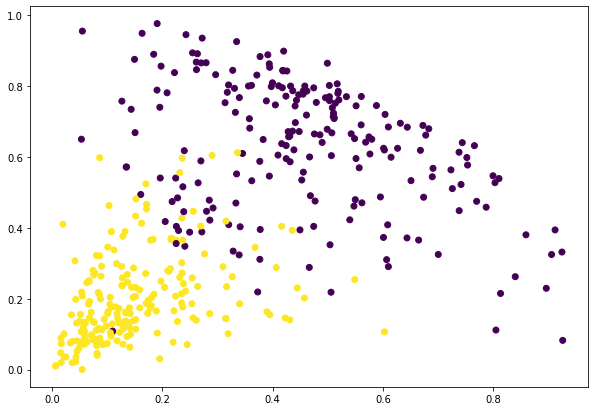

In [39]:
plt.figure(figsize=(10, 7))  
plt.scatter(scaled_df['Milk'], scaled_df['Grocery'], c=cluster.labels_) 

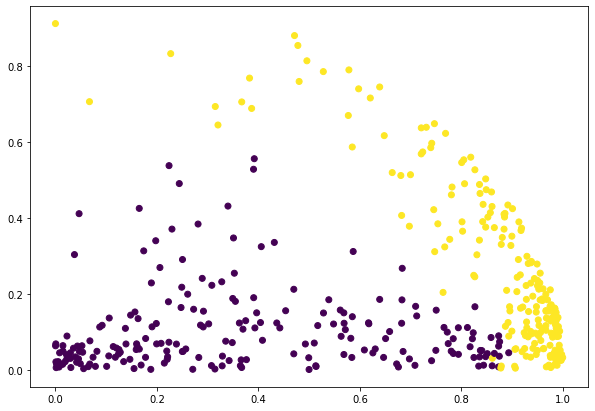

In [40]:
plt.figure(figsize=(10, 7))  
plt.scatter(scaled_df['Fresh'], scaled_df['Frozen'], c=cluster.labels_) 

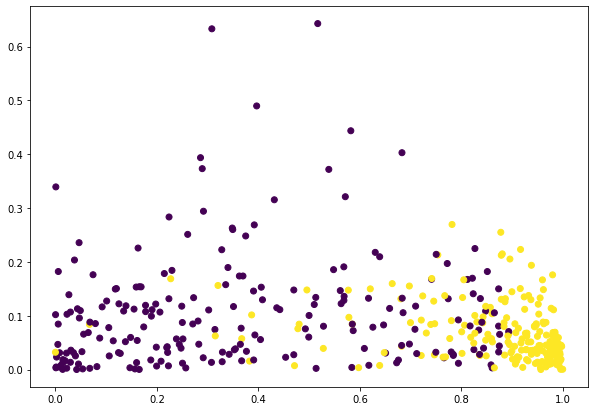

In [41]:
plt.figure(figsize=(10, 7))  
plt.scatter(scaled_df['Fresh'], scaled_df['Delicassen'], c=cluster.labels_) 

Text(0.5, 1.0, 'Projection of the clustering on a the axis of the PCA')

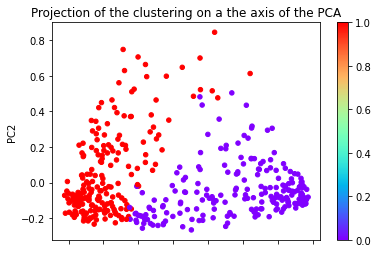

In [42]:
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(scaled_df)
data_reduced = pd.DataFrame(data_reduced)

ax = data_reduced.plot(kind='scatter', x=0, y=1, c=preds, cmap='rainbow')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Projection of the clustering on a the axis of the PCA')

**Using Complete Linkage**

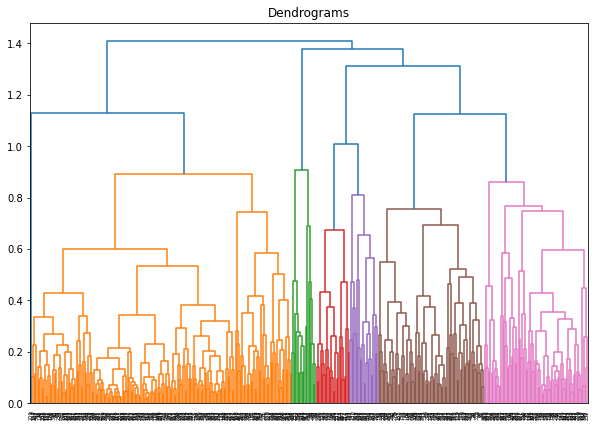

In [43]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(scaled_df, method='complete'))

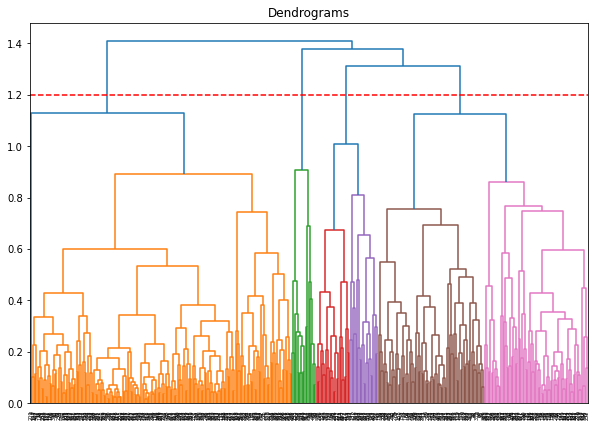

In [44]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(scaled_df, method='complete'))
plt.axhline(y=1.2, color='r', linestyle='--')

In [45]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')  
preds = cluster.fit_predict(scaled_df)

Text(0.5, 1.0, 'Projection of the clustering on a the axis of the PCA')

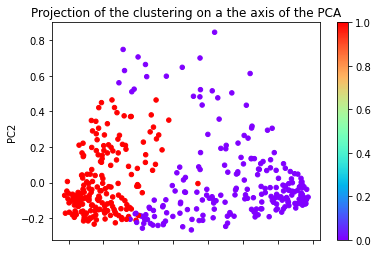

In [46]:
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(scaled_df)
data_reduced = pd.DataFrame(data_reduced)

ax = data_reduced.plot(kind='scatter', x=0, y=1, c=preds, cmap='rainbow')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Projection of the clustering on a the axis of the PCA')

## Conclusion
***

From the above analysis we can conclude that our KMeans Clustering algorithm has an elbow (optimal K-value) around 10 clusters according to the scree elbow method, and 17 when optimizing silhouette scores. When looking at how those optimal k-values graph on the PCA visual it is a little hard to determine how the clusters separate. When using the HCA method and our dendogram we end up splitting into 2 clusters. Comparing the different ways that we can cluster our data is interesting, and I am curious what our clusters can be used after having them.

## References
***

1. [Hierarchical Algomerative Clustering Algorithm Example in Python](https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019)
2. [PRAW: Reddit API](https://praw.readthedocs.io/en/stable/index.html)